In [ ]:
# default_exp funcs.tt_rescale

In [ ]:
%load_ext autoreload
%autoreload 2

# Training loop simulator learning

In [ ]:
# export
from decode_fish.imports import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.plotting import *
from decode_fish.funcs.predict import *
import torch.nn.functional as F
from torch import distributions as D
from torch.utils.data import DataLoader
import torch_optimizer
from decode_fish.engine.microscope import Microscope, get_roi_filt_inds, extract_psf_roi, mic_inp_apply_inds, add_pos_noise, concat_micro_inp
from decode_fish.engine.model import UnetDecodeNoBn
from decode_fish.engine.point_process import PointProcessUniform, get_phased_ints
from decode_fish.engine.gmm_loss import PointProcessGaussian
import shutil
import wandb
import kornia

from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *
# from decode_fish.funcs.visualization vimport get_simulation_statistics

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
losses = []

In [ ]:
#export 
def rescale_train(cfg,
          model, 
          microscope,
          post_proc,
          dl, 
          optim_dict):
    
    save_dir = Path(cfg.output.save_dir)
    model.cuda()

    # Load codebook 
    if 'codebook' in cfg:
        code_ref, targets = hydra.utils.instantiate(cfg.codebook)

    # Controls which genmodel parameters are optimized
    for name, p in microscope.named_parameters():
        if name == 'channel_facs':
            p.requires_grad = True
        else:
            False

    for batch_idx in range(0, cfg.training.num_iters+1):

        optim_dict['optim_mic'].zero_grad()

        with torch.no_grad():
            
            ret_dict = next(iter(dl))
            x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'] 
            zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
        
            x = x * microscope.get_ch_mult().detach()
            colshift_crop = get_color_shift_inp(microscope.color_shifts, microscope.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
        
            out_inp = model.tensor_to_dict(model(torch.concat([x, colshift_crop], 1)))
            proc_out_inp = post_proc.get_micro_inp(out_inp)
        
        if len(proc_out_inp[1]) > 0:
        
            ch_out_inp = microscope.get_single_ch_inputs(*proc_out_inp, ycrop=ycrop.flatten(), xcrop=xcrop.flatten())

            # Get ch_fac loss
            ch_inds = ch_out_inp[0][1]
            int_vals = ch_out_inp[-2]

            int_means = torch.ones(cfg.genm.exp_type.n_channels).cuda()
            for i in range(cfg.genm.exp_type.n_channels):
                if i in ch_inds:
                    int_means[i] = int_vals[ch_inds == i].mean() / int_vals.mean()

            ch_fac_loss = torch.sqrt(torch.mean((microscope.channel_facs - microscope.channel_facs.detach() / int_means)**2))

            ch_fac_loss.backward()
            torch.nn.utils.clip_grad_norm_(microscope.parameters(), max_norm=cfg.training.mic.grad_clip, norm_type=2)

            optim_dict['optim_mic'].step()
            optim_dict['sched_mic'].step()
            
            losses.append(ch_fac_loss.item())

            # Logging
            if batch_idx % cfg.output.log_interval == 0:

                print(ch_fac_loss)

In [ ]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_22/norm:nonexmean_diff:True//train.yaml')

cfg.output.log_interval = 20
cfg.training.bs = 30
cfg.genm.microscope.norm='none'

cfg.training.num_iters = 5000
cfg.training.mic.opt.lr


0.00025

In [ ]:
cfg.training.mic.opt.lr = 0.0005

In [ ]:
cfg.data_path.image_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images150.tif'

In [ ]:
psf, noise, micro = load_psf_noise_micro(cfg)
post_proc = hydra.utils.instantiate(cfg.post_proc_isi)
post_proc.samp_threshold = 0.5

In [ ]:
img_3d, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)
7 volumes


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
model = hydra.utils.instantiate(cfg.network, inp_scale=1., inp_offset=1.)

psf  .to('cuda')
model.to('cuda')
micro.to('cuda')

Microscope(
  (psf): LinearInterpolatedPSF(
    (forward_nonlin): Identity()
  )
  (noise): sCMOS()
)

In [ ]:
model = load_model_state(model, Path(cfg.output.save_dir)/'model.pkl').cuda()
micro.load_state_dict(torch.load(Path(cfg.output.save_dir)/'microscope.pkl'), strict=False)

<All keys matched successfully>

In [ ]:
tra = cpu(micro.channel_facs)

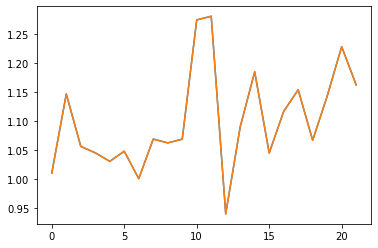

In [ ]:
plt.plot(tra)
plt.plot(cpu(micro.channel_facs))

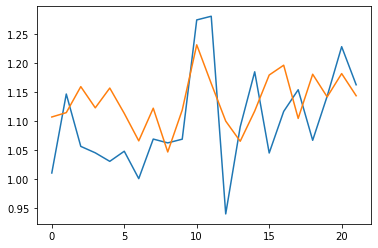

In [ ]:
plt.plot(tra)
plt.plot(cpu(micro.channel_facs))

In [ ]:
micro.channel_facs

Parameter containing:
tensor([1.1071, 1.1146, 1.1594, 1.1228, 1.1569, 1.1133, 1.0660, 1.1222, 1.0468,
        1.1190, 1.2314, 1.1649, 1.1000, 1.0652, 1.1173, 1.1794, 1.1963, 1.1046,
        1.1807, 1.1417, 1.1818, 1.1437], device='cuda:0', requires_grad=True)

In [ ]:
optim_dict = {}
optim_dict['optim_mic'] = hydra.utils.instantiate(cfg.training.mic.opt, params=micro.parameters())
optim_dict['sched_mic'] = hydra.utils.instantiate(cfg.training.mic.sched, optimizer=optim_dict['optim_mic'])

In [ ]:
code_ref, targets = hydra.utils.instantiate(cfg.codebook)
post_proc.codebook = torch.tensor(code_ref)

In [ ]:
rescale_train(cfg=cfg,
     model=model, 
     microscope=micro, 
     post_proc=post_proc,
     dl=decode_dl, 
     optim_dict=optim_dict)

tensor(0.0816, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0970, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0795, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0722, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.3458, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.1050, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0998, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.1378, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.3522, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0659, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0783, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0667, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.2842, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0582, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0730, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0625, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0711, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0761, device='cuda:0',

KeyboardInterrupt: 

In [ ]:
!nbdev_build_lib

In [ ]:
plt.plot(losses)